<a href="https://colab.research.google.com/github/orestislampridis/advanced_ML_project/blob/master/black_box_explanation_ADASYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [1]:
import random
import pandas as pd
import numpy as np
import pickle
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots
!pip install lime
import lime.lime_tabular
!pip install shap
import shap
!pip install anchor_exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Initialize dataframe by reading csv from github and print descriptions of each feature for later reference

In [2]:
url = 'https://raw.githubusercontent.com/orestislampridis/advanced_ML_project/master/dataset/africa_recession.csv'
url_descriptions = 'https://raw.githubusercontent.com/orestislampridis/advanced_ML_project/master/dataset/VariableDefinitions.csv'

df = pd.read_csv(url, error_bad_lines=False)

mapping = pd.read_csv(url_descriptions, skiprows=1, header=None, index_col=0, squeeze=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

class_names = ["no recession", "recession"]
print(mapping)

0
pop                                                Population (in millions)
emp                                 Number of persons engaged (in millions)
emp_to_pop_ratio              Ratio of Employed Persons to Total Population
hc                        Human capital index, based on years of schooli...
ccon                      Real consumption of households and government,...
cda                       Real domestic absorption, (real consumption pl...
cn                          Capital stock at current PPPs (in mil. 2011US$)
ck                          Capital services levels at current PPPs (USA=1)
ctfp                                      TFP level at current PPPs (USA=1)
cwtfp                     Welfare-relevant TFP levels at current PPPs (U...
rconna                    Real consumption at constant 2011 national pri...
rdana                     Real domestic absorption at constant 2011 nati...
rnna                      Capital stock at constant 2011 national prices...
rkna      

Train random forest as black box model with ADASYN as class imbalance method and plot feature importance by using eli5 on black box model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_resampled,y_resampled)

y_predicted = model.predict(X_test.values)

perm = PermutationImportance(model).fit(X_resampled, y_resampled)
eli5.show_weights(perm, feature_names=X.columns.tolist(), top=100)


Print evaluation scores for our black box model

In [9]:
def evaluation_scores(test, prediction, class_names=None):
    print('Accuracy:', accuracy_score(test, prediction)) 
    print('-'*60)
    print('classification report:\n\n', classification_report(y_true=test, y_pred=prediction, target_names=class_names)) 

evaluation_scores(y_test, y_predicted, class_names=class_names)


Accuracy: 0.9344262295081968
------------------------------------------------------------
classification report:

               precision    recall  f1-score   support

no recession       0.94      0.99      0.97       112
   recession       0.75      0.30      0.43        10

    accuracy                           0.93       122
   macro avg       0.85      0.65      0.70       122
weighted avg       0.93      0.93      0.92       122



Explain a particular instance (local interpretation) for no recession class

In [10]:
element = 0
sample = y_test.to_list().index(element)

print('Reference:', y_test.iloc[sample])
print('Predicted:', y_predicted[sample])
eli5.show_prediction(model, X_test.iloc[sample], 
                     feature_names=X.columns.tolist(), show_feature_values=True)

Reference: 0
Predicted: 0


Explain a particular instance (local interpretation) for recession class that got assigned to the correct label

In [11]:
element = 1
sample = list(y_predicted).index(element)

print('Reference:', y_test.iloc[sample])
print('Predicted:', y_predicted[sample])
eli5.show_prediction(model, X_test.iloc[sample], 
                     feature_names=X.columns.tolist(), show_feature_values=True)

Reference: 1
Predicted: 1


Partial Dependency Plot that shows how a feature affects the predictions of our black box model

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


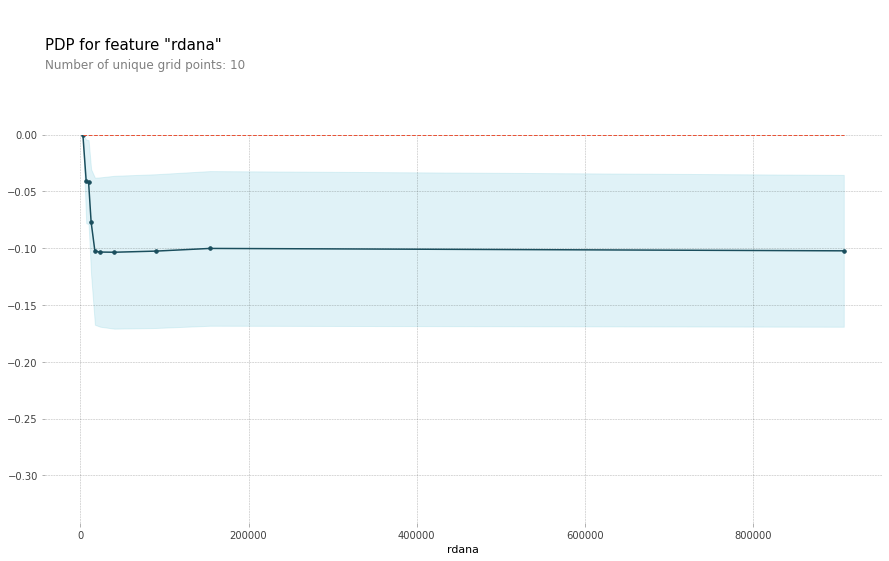

In [12]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

# plot the PD univariate plot
plot_pdp(model, X_train, 'rdana')

Local interpretation using the amazing Lime

In [8]:
# Change the number below to test other instances
sample = 0
newXtest = X_test.values[sample]
y_true = y_test.values[sample]
y_pp = y_predicted[sample]
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names=X_train.columns.values.tolist()
                                                   ,class_names=y_train.unique())
predict_fn = lambda x: model.predict_proba(x).astype(float)
explanation = explainer.explain_instance(X_test.values[0], predict_fn, num_features=10)
explanation.show_in_notebook()


Next, we use Shap explainer to get global and local explanations from our black box model

In [13]:
# load JS visualization code to notebook
shap.initjs()

shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test)

print('Expected Value: ', shap_explainer.expected_value)

Expected Value:  [0.49677991 0.50322009]


Feature Importances with SHAP

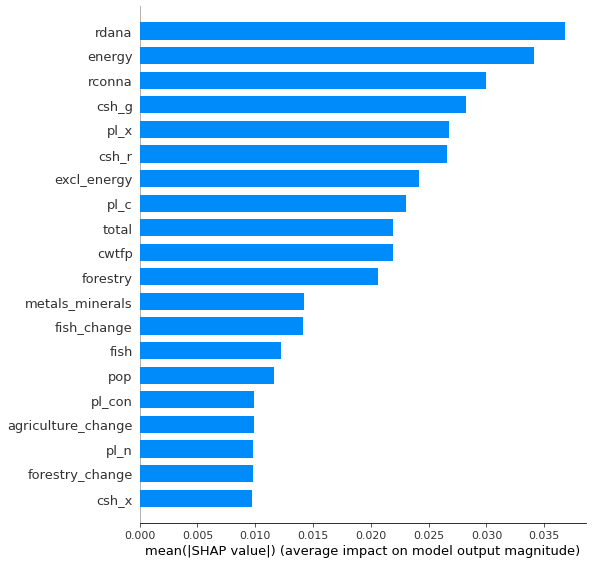

In [14]:
shap.summary_plot(shap_values[0], X_test, plot_type="bar")

Create a dependence plot using Shap to show the effect of a single feature across the whole dataset

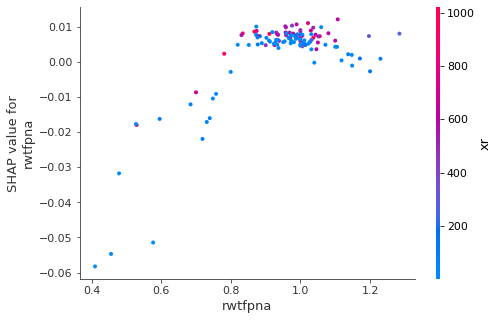

In [15]:
shap.initjs()
feature = "rwtfpna"

shap.dependence_plot(feature, shap_values[0], X_test,)

Summarize the effects all the features in the model's prediction

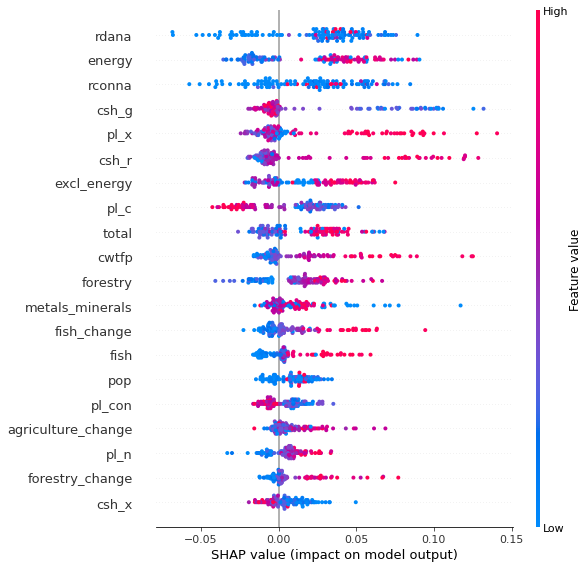

In [16]:
shap.summary_plot(shap_values[0], X_test)

Visualize the explanation for a given instance (local explanation)

In [17]:
# load JS visualization code to notebook

shap.initjs()

# change the value below to change instance
sample=0

shap.force_plot(shap_explainer.expected_value[0], shap_values[0][sample,:], X_test.iloc[sample,:])

Bonus! Explanations using *Anchor*

In [18]:
from anchor import anchor_tabular

explainer = anchor_tabular.AnchorTabularExplainer(['no recession', 'recession'], X.columns, X_resampled)

idx = 1
print('Prediction: ', explainer.class_names[model.predict(np.array(X_test)[idx].reshape(1, -1))[0]])


exp = explainer.explain_instance(np.array(X_test)[idx], model.predict, threshold=0.8, batch_size=30)
exp.show_in_notebook()

Prediction:  no recession
